<a href="https://colab.research.google.com/github/bhushanrajs/sciml_project/blob/main/project_PySR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbolic Regression

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.5"
export JULIA_PKG_PRECOMPILE_AUTO=0
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  echo "Installing PyCall.jl..."
  julia -e 'using Pkg; Pkg.add("PyCall"); Pkg.build("PyCall")'
  julia -e 'println("Success")'

fi

Installing Julia 1.8.5 on the current Colab Runtime...
2023-12-31 04:27:27 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.5-linux-x86_64.tar.gz [130873886/130873886] -> "/tmp/julia.tar.gz" [1]
Installing PyCall.jl...
  Installing known registries into `~/.julia`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed VersionParsing ── v1.3.0
   Installed MacroTools ────── v0.5.12
   Installed Parsers ───────── v2.8.1
   Installed PyCall ────────── v1.96.4
   Installed Conda ─────────── v1.10.0
   Installed JSON ──────────── v0.21.4
   Installed Preferences ───── v1.4.1
   Installed PrecompileTools ─ v1.2.0
    Updating `~/.julia/environments/v1.8/Project.toml`
  [438e738f] + PyCall v1.96.4
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [8f4d0f93] + Conda v1.10.0
  [682c06a0] + JSON v0.21.4
  [1914dd2f] + MacroTools v0.5.12
  [69de0a69] + Parsers v2.8.1
  [aea7be01] + PrecompileTools v1.2.0
  [21216c

Install PySR and PyTorch-Lightning:

In [2]:
%pip install -Uq pysr pytorch_lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.7 MB/s eta 0:00:00


In [3]:
from julia import Julia

julia = Julia(compiled_modules=False, threads="auto")
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

In [4]:
import pysr

# We don't precompile in colab because compiled modules are incompatible static Python libraries:
pysr.install(precompile=False)

Julia Version 1.8.5
Commit 17cfb8e65ea (2023-01-08 06:45 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
      Ubuntu 22.04.3 LTS
  uname: Linux 6.1.58+ #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023 x86_64 x86_64
  CPU: Intel(R) Xeon(R) CPU @ 2.30GHz: 
              speed         user         nice          sys         idle          irq
       #1  2299 MHz        875 s          0 s        241 s        268 s          0 s
       #2  2299 MHz        731 s          0 s        237 s        404 s          0 s
  Memory: 12.674789428710938 GB (11525.90625 MB free)
  Uptime: 156.2 sec
  Load Avg:  2.25  1.02  0.39
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, haswell)
  Threads: 1 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/lib64-nvidia
  JULIA_PROJECT = @pysr-0.16.7
  JULIA_PKG_PRECOMPILE_AUTO = 0
  TCLLIBPATH = /usr/share/tcltk/tcllib1.20
  HOME = /root
  PYTHONPATH = /env/python
  LIBRARY_PATH = /usr/local/cuda/lib64/stubs
  PATH = /opt/bin:/usr/loc

[ Info: Julia version info
[ Info: Julia executable: /usr/local/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /usr/bin/python3
│     libpython: /usr/lib/x86_64-linux-gnu/libpython3.10.so.1.0
│ Python:
│     python: /usr/bin/python3
└     libpython: 
    Updating registry at `~/.julia/registries/General.toml`
     Cloning git-repo `https://github.com/MilesCranmer/SymbolicRegression.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed SIMDTypes ──────────────────────── v0.1.0
   Installed BitTwiddlingConvenienceFunctions ─ v0.1.5
   Installed IrrationalConstants ────────────── v0.2.2
   Installed ScientificTypesBase ────────────── v3.0.0
   Installed Adapt ──────────────────────────── v3.7.2
   Installed Tricks ─────────────────────────── v0.1.8
   Installed DiffRules ──────────────────────── v1.15.1
   Installed DynamicExpressions 

In [5]:
import sympy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/bhushanrajs/distribution_factors_pySR/main/skew_0.csv')



# bridge geometry data
L = df['L'] # span length in ft.
S = df['S'] # girder spacing in ft.
w_oh = df['w_oh'] # overhang width in ft.
ts = df['ts'] # thickness of overhang in ft.
girder = df['girderName']
D = df['D']


# normalizing bending moments with respect to line analysis
n_bm1 = df['n_bm1']
n_bm2 = df['n_bm2']
n_bm3 = df['n_bm3']
n_bm4 = df['n_bm4']

# normalizing vertical reactions with respect to line analysis
n_r1 = df['n_r1']
n_r2 = df['n_r2']
n_r3 = df['n_r3']
n_r4 = df['n_r4']

In [9]:
# sample data from leve rule
# n_r1 = (w_oh + S) / S

In [10]:
X = np.stack((L, w_oh, S, D), axis=-1)
y = n_r1

In [11]:
# Learn equations
default_pysr_params = dict(
    populations=30,
    model_selection="best",
)

# model = PySRRegressor(
#     niterations=30,
#     binary_operators=['+', '-', '*', '/', '^'],
#     unary_operators=["square", "cube", "sqrt"],
#     **default_pysr_params
# )

model = PySRRegressor(
    niterations=50,  # < Increase me for better results
    binary_operators=['+', '-', '*', '/', '^', "physics(x, y) = x^2 / y"],
    unary_operators=["square", "cube", "sqrt", "inv(x) = 1/x"],
        # ^ Custom operator (julia syntax)
    extra_sympy_mappings={"inv": lambda x: 1 / x,
                          "physics": lambda x, y: x**2 / y},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
    **default_pysr_params
)

model.fit(X, y)

print(model)

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1271: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:240: UserWarning: Julia has already started. The new Julia options {'threads': 2} will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:60: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://astroautomata.com/PySR/tuning/
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.020e+03
Head worker occupation: 2.4%
Progress: 5 / 1500 total iterations (0.333%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.280e-02  1.594e+01  y = 0.98279
2           1.244e-02  2.793e-02  y = square(0.98279)
3           1.244e-02  3.103e-04  y = cube(sqrt(0.97579))
5           9.824e-03  1.181e-01  y = (physics(-2.1289, x₁) ^ -0.048705)
7           8.920e-03  4.830e-02  y = ((0.66325 ^ square(inv(x₁))) ^ 0.99022)
10          7.618e-03  5.257e-02  y = (physics(sqrt((x₀ - x₂) / x₂), x₁) ^ -0.048705)
11          6.733e-03  1.235e-01  y = (inv(physics(x₃, (x₁ ^ x₂) / x₀)) ^ inv(x₃))
12          3.545e-03  6.415e-01  y = (physics(physics(sqrt((x₀ - x₂) / x₂), x₁), x₁) ^ -0.04870...
                                  5)
14          2.179e-03  2.432e-01  y = (physics(physics(sqrt(((x₀ - x₂) * 0.72927) / x₂), x₁), x₁...
          

In [12]:
model1 = model
model1.sympy()

((x0 - x3)/(x1**3 + x2))**(-0.11825741)

In [13]:
n_r1_pred = model1.predict(X)

print("Default selection MSE:", np.power(n_r1_pred - y, 2).mean())

Default selection MSE: 0.0005113027181610683


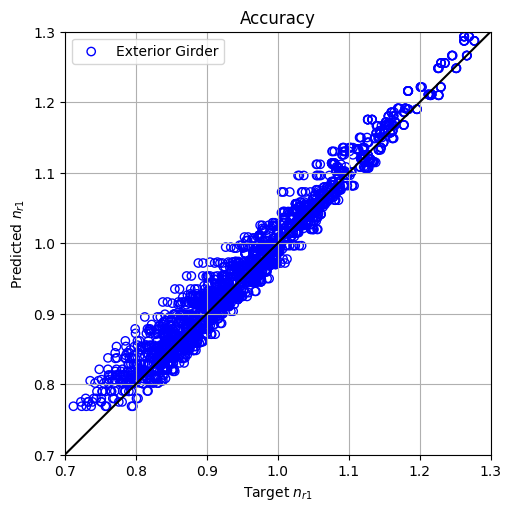

In [14]:
x_line = [0.5, 1.5]
y_line = [0.5, 1.5]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=n_r1, y=n_r1_pred, marker='o', c='none', edgecolor='b', label='Exterior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((0.7,1.3))
plt.ylim((0.7,1.3))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

In [15]:
model1.latex()

'\\left(\\frac{x_{0} - x_{3}}{x_{1}^{3} + x_{2}}\\right)^{-0.118}'

In [16]:
y2 = n_r2

model.fit(X, y2)

print(model)


/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1806: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1271: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/julia_helpers.py:240: UserWarning: Julia has already started. The new Julia options {'threads': 2} will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysr/sr.py:60: UserWarning: You are using the `^` operator, but have not set up `constraints` for it. This may lead to overly complex expressions. One typical constraint is to use `constraints={..., '^': (-1, 1)}`, which will allow arbitrary-complexity base (-1) but only powers such as a constant or variable (1). For more tips, please see https://astroautomata.com/PySR/tuning/
  warnin


Expressions evaluated per second: 2.590e+03
Head worker occupation: 0.2%
Progress: 6 / 1500 total iterations (0.400%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.228e-01  1.594e+01  y = 0.51664
2           8.461e-03  3.271e+00  y = inv(x₃)
3           7.374e-03  1.376e-01  y = (0.78295 - 0.71586)
5           7.174e-03  1.371e-02  y = cube(inv(physics(1.359, 0.6691)))
6           4.212e-03  5.325e-01  y = inv(physics(x₁, square(square(0.76064))))
11          2.917e-03  7.347e-02  y = cube(inv((square(square(x₁)) / x₀) - (-0.86875 + -0.9398))...
                                  )
13          2.876e-03  7.162e-03  y = cube(inv(((square(square(x₁)) - -0.86875) / x₀) - (-0.8687...
                                  5 + -0.9398)))
14          2.764e-03  3.963e-02  y = cube(inv((square(square(x₁ + square(0.50525))) / x₀) - (-0...
                                  .868

In [36]:
model2 = model
model2.sympy()

(0.25390267*sqrt(x0) - 0.66841435*x1)/sqrt(x0)

In [37]:
n_r2_pred = model2.predict(X)

print("Default selection MSE:", np.power(n_r2_pred - y2, 2).mean())

Default selection MSE: 0.0005647099641806667


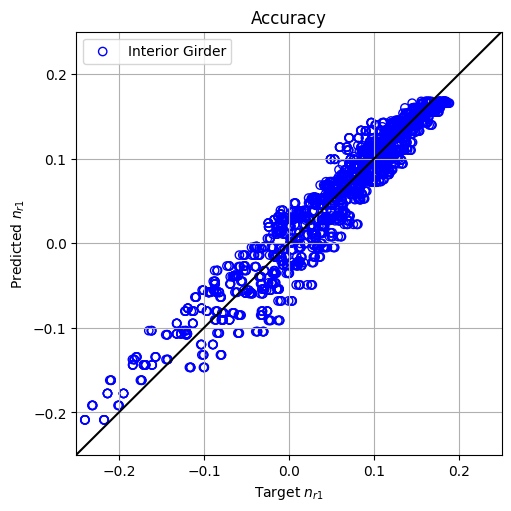

In [38]:
x_line = [-0.25, 0.25]
y_line = [-0.25, 0.25]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), constrained_layout = True)

ax1.scatter(x=n_r2, y=n_r2_pred, marker='o', c='none', edgecolor='b', label='Interior Girder')
ax1.plot(x_line, y_line, c = "k")
ax1.set_title('Accuracy')
ax1.legend()
plt.xlim((-0.25, 0.25))
plt.ylim((-0.25, 0.25))
ax1.set_xlabel('Target $n_{r1}$')
ax1.set_ylabel('Predicted $n_{r1}$')
ax1.grid()

In [40]:
model2.latex()

'\\frac{0.254 \\sqrt{x_{0}} - 0.668 x_{1}}{\\sqrt{x_{0}}}'